## Inference and Validation
<b>Inference</b> is utilizing a trained network to perform predictions.
To test for overfitting while training, measure the performance on data in the validation set (separate from the training set).
One way to avoid overfitting: dropout

Typically 10-20% of original dataset is held out for testing and validation

In [3]:
import torch
from torchvision import datasets, transforms

# define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# download and load test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Processing...
Done!


Q: why is test and train data the same? don't we have to takea  portion of it

### Create a model

In [4]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # flatten input tensor
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

### Forward pass with one batch from test set

In [5]:
model = Classifier()

images, labels = next(iter(testloader))
# get class probabilities
ps = torch.exp(model(images))
# make sure the shape is appropriate: 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


In [6]:
top_p, top_class = ps.topk(1, dim=1) 
# topk will return the highest k value, or the most likely class

# look at the most likely class for the first 10 examples
print(top_class[:10,:])

tensor([[2],
        [7],
        [7],
        [7],
        [7],
        [2],
        [2],
        [2],
        [1],
        [7]])


### Determine if predicted classes matches the labels
Can just compare the top class and labels, but they are different tensors as top_class is (64, 1) and labels is (64). They need to match

In [14]:
equals = top_class == labels.view(*top_class.shape)
print(equals.shape)

torch.Size([64, 1])


Here we will calculate the percentage of correct predictions by dividing the sum of all values by the number of values (this works because correct predictions are 1, incorrect are 0). Use .mean()

Problem: 'equals' has a type torch.ByteTensor, which torch.mean cannot act on. Need to convert equals to a float tensor below:

In [15]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 7.8125%


### Train the network

In [17]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # turn off gradients for validation to save memory and computation
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.512..  Test Loss: 0.455..  Test Accuracy: 0.833
Epoch: 2/30..  Training Loss: 0.388..  Test Loss: 0.471..  Test Accuracy: 0.840
Epoch: 3/30..  Training Loss: 0.356..  Test Loss: 0.391..  Test Accuracy: 0.860
Epoch: 4/30..  Training Loss: 0.333..  Test Loss: 0.391..  Test Accuracy: 0.863
Epoch: 5/30..  Training Loss: 0.319..  Test Loss: 0.374..  Test Accuracy: 0.867
Epoch: 6/30..  Training Loss: 0.302..  Test Loss: 0.368..  Test Accuracy: 0.868
Epoch: 7/30..  Training Loss: 0.294..  Test Loss: 0.366..  Test Accuracy: 0.871
Epoch: 8/30..  Training Loss: 0.285..  Test Loss: 0.432..  Test Accuracy: 0.864
Epoch: 9/30..  Training Loss: 0.274..  Test Loss: 0.350..  Test Accuracy: 0.875
Epoch: 10/30..  Training Loss: 0.266..  Test Loss: 0.367..  Test Accuracy: 0.873
Epoch: 11/30..  Training Loss: 0.259..  Test Loss: 0.367..  Test Accuracy: 0.873
Epoch: 12/30..  Training Loss: 0.254..  Test Loss: 0.364..  Test Accuracy: 0.881
Epoch: 13/30..  Training Loss: 0.249.

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

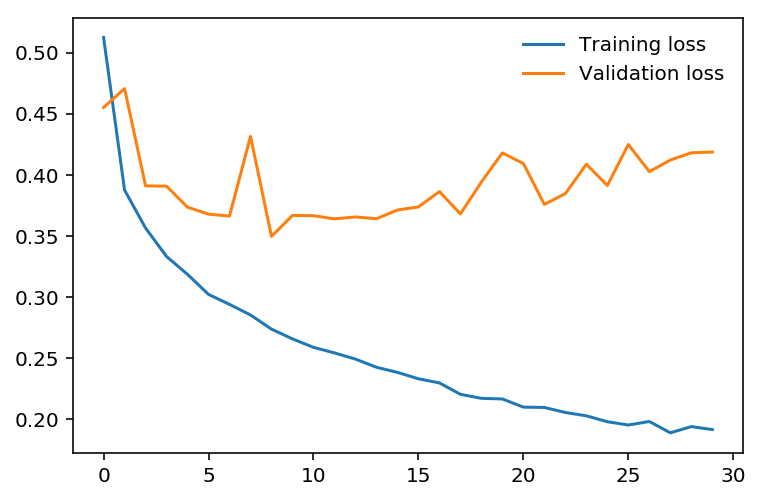

In [20]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

As seen in the figure above, the model is getting progressively more accurate at classifying the training set, but not the validation set. This is a case of overfitting and being unable to generalize new data. In the next assignment, I will use dropouts to prevent overfitting the training set.